# 6-1 프로젝트: CutMix 또는 Mixup 비교실험 하기

|평가 기준|상세 설명|
|------|---|
|1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?|CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.|
|2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?|각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점을 서술하였음|
|3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?|기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.|

In [1]:
#주요 라이브러리 버전을 확인
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [2]:
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow_datasets as tfds

## 1. Augmentation을 적용한 데이터셋 만들기

In [3]:
#데이터 불러오기
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [4]:
print(len(ds_train))
print(len(ds_test))

12000
8580


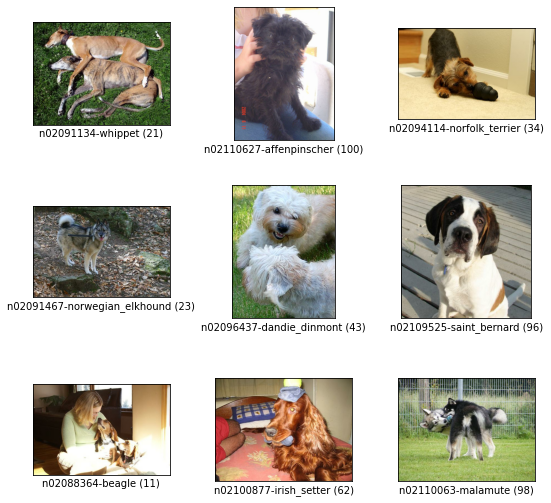

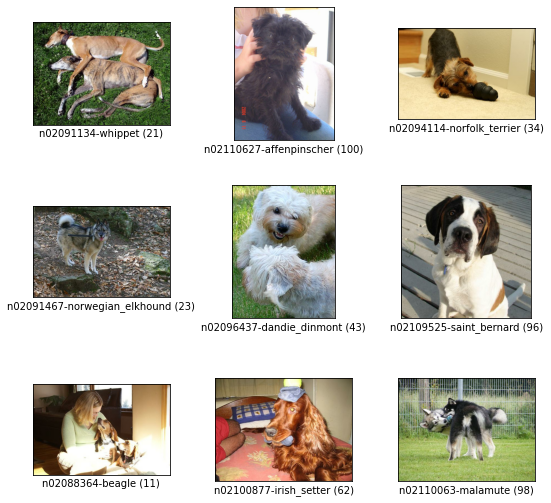

In [5]:
#다운로드한 데이터를 확인
tfds.show_examples(ds_train, ds_info)

In [6]:
#기본적인 전처리 함수
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
#augmentation
def augment(image, label):
    #image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [8]:
#one-hot인코딩
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    print(label.shape)
    return image, label

In [9]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [10]:
# 데이터셋(ds)을 가공하는 메인함수2
def apply_normalize_on_dataset2(ds, is_test=False, batch_size=16, with_aug=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


 cutmix

In [11]:
#cutmix
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]

    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)

    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)

    return x_min, y_min, x_max, y_max

In [12]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)

    return mixed_img

# mix two labels
def mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [13]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]

        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    print(mixed_labels.shape)
    return mixed_imgs, mixed_labels


mixup

In [14]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b

    return mixed_image, mixed_label

In [15]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

## 2. 모델 만들기

In [16]:
#resnet50 함수로 구현
def resnet50_model(num_classes):
    res_model = keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    )

    model = keras.models.Sequential([
        res_model,
        keras.layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])

    return model

In [17]:
#1. No Augmentation
num_classes = ds_info.features["label"].num_classes

resnet50 = resnet50_model(num_classes)

In [18]:
#2. Augmentation
aug_resnet50 = resnet50_model(num_classes)

In [19]:
#3. CutMix 적용
cutmix_resnet50 = resnet50_model(num_classes)

In [20]:
#4. Mixup 적용
mixup_resnet50 = resnet50_model(num_classes)

## 모델 훈련하기

In [21]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

(None, 120)
(None, 120)
(None, 120)


In [22]:
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset2(ds_train, with_mixup=True)

(16, 120)


In [23]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 10

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/10
750/750 [==============================] - 164s 203ms/step - loss: 2.2236 - accuracy: 0.4487 - val_loss: 3.3996 - val_accuracy: 0.2114
Epoch 2/10
750/750 [==============================] - 151s 202ms/step - loss: 0.6904 - accuracy: 0.8109 - val_loss: 1.1087 - val_accuracy: 0.6746
Epoch 3/10
750/750 [==============================] - 151s 202ms/step - loss: 0.2171 - accuracy: 0.9565 - val_loss: 0.9145 - val_accuracy: 0.7308
Epoch 4/10
750/750 [==============================] - 151s 202ms/step - loss: 0.0614 - accuracy: 0.9956 - val_loss: 0.8941 - val_accuracy: 0.7380
Epoch 5/10
750/750 [==============================] - 151s 202ms/step - loss: 0.0296 - accuracy: 0.9981 - val_loss: 0.9075 - val_accuracy: 0.7413
Epoch 6/10
750/750 [==============================] - 167s 222ms/step - loss: 0.0174 - accuracy: 0.9998 - val_loss: 0.9221 - val_accuracy: 0.7396
Epoch 7/10
750/750 [==============================] - 151s 202ms/step - loss: 0.0130 - accuracy: 0.9999 - val_loss: 0.9318 -

In [37]:
ds_train_no_aug

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.float32)>

In [24]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 10

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 159s 203ms/step - loss: 2.2949 - accuracy: 0.4279 - val_loss: 2.9397 - val_accuracy: 0.2828
Epoch 2/10
750/750 [==============================] - 151s 202ms/step - loss: 0.9653 - accuracy: 0.7249 - val_loss: 1.2723 - val_accuracy: 0.6376
Epoch 3/10
750/750 [==============================] - 151s 202ms/step - loss: 0.4850 - accuracy: 0.8692 - val_loss: 1.2134 - val_accuracy: 0.6560
Epoch 4/10
750/750 [==============================] - 151s 202ms/step - loss: 0.2554 - accuracy: 0.9412 - val_loss: 0.9940 - val_accuracy: 0.7097
Epoch 5/10
750/750 [==============================] - 151s 202ms/step - loss: 0.1369 - accuracy: 0.9755 - val_loss: 0.9895 - val_accuracy: 0.7248
Epoch 6/10
750/750 [==============================] - 167s 222ms/step - loss: 0.0851 - accuracy: 0.9862 - val_loss: 1.0103 - val_accuracy: 0.7220
Epoch 7/10
750/750 [==============================] - 152s 202ms/step - loss: 0.0498 - accuracy: 0.9941 - val_loss: 0.9907 -

In [36]:
ds_train_aug

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.float32)>

In [25]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 10

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 161s 204ms/step - loss: 3.8251 - accuracy: 0.2139 - val_loss: 3.4447 - val_accuracy: 0.1915
Epoch 2/10
750/750 [==============================] - 152s 203ms/step - loss: 2.9218 - accuracy: 0.4386 - val_loss: 1.2744 - val_accuracy: 0.6442
Epoch 3/10
750/750 [==============================] - 153s 204ms/step - loss: 2.6181 - accuracy: 0.5408 - val_loss: 1.2125 - val_accuracy: 0.6727
Epoch 4/10
750/750 [==============================] - 153s 203ms/step - loss: 2.4086 - accuracy: 0.6077 - val_loss: 1.3644 - val_accuracy: 0.6290
Epoch 5/10
750/750 [==============================] - 153s 204ms/step - loss: 2.2591 - accuracy: 0.6618 - val_loss: 1.3390 - val_accuracy: 0.6300
Epoch 6/10
750/750 [==============================] - 153s 204ms/step - loss: 2.1223 - accuracy: 0.6982 - val_loss: 1.2444 - val_accuracy: 0.6617
Epoch 7/10
750/750 [==============================] - 153s 204ms/step - loss: 2.0344 - accuracy: 0.7253 - val_loss: 1.2937 -

In [26]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 10

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # mixup
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 161s 205ms/step - loss: 3.7507 - accuracy: 0.2353 - val_loss: 3.9648 - val_accuracy: 0.1125
Epoch 2/10
750/750 [==============================] - 153s 204ms/step - loss: 2.8805 - accuracy: 0.4740 - val_loss: 1.7454 - val_accuracy: 0.5210
Epoch 3/10
750/750 [==============================] - 153s 204ms/step - loss: 2.5964 - accuracy: 0.5791 - val_loss: 1.6047 - val_accuracy: 0.5691
Epoch 4/10
750/750 [==============================] - 153s 204ms/step - loss: 2.3889 - accuracy: 0.6587 - val_loss: 1.2662 - val_accuracy: 0.6581
Epoch 5/10
750/750 [==============================] - 153s 204ms/step - loss: 2.2623 - accuracy: 0.7101 - val_loss: 1.3799 - val_accuracy: 0.6266
Epoch 6/10
750/750 [==============================] - 153s 204ms/step - loss: 2.1630 - accuracy: 0.7384 - val_loss: 1.2238 - val_accuracy: 0.6679
Epoch 7/10
750/750 [==============================] - 153s 204ms/step - loss: 2.0992 - accuracy: 0.7723 - val_loss: 1.2649 -

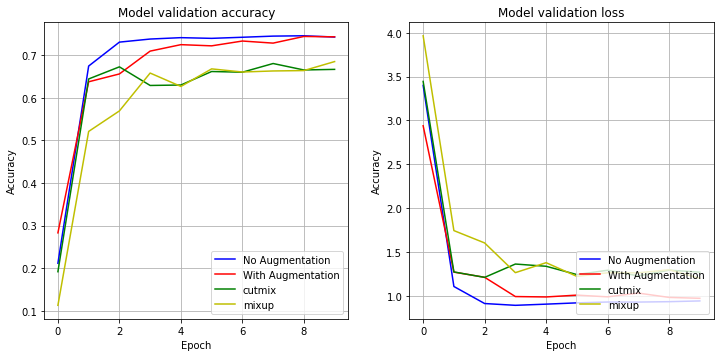

In [64]:
#validation 과정 시각화
plt.figure(figsize=(12, 12))

plt.subplot(2,2,1)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','cutmix','mixup'], loc='lower right')
plt.grid(True)

plt.subplot(2,2,2)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_mixup.history['val_loss'], 'y')
plt.title('Model validation loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','cutmix','mixup'], loc='lower right')
plt.grid(True)
plt.show()

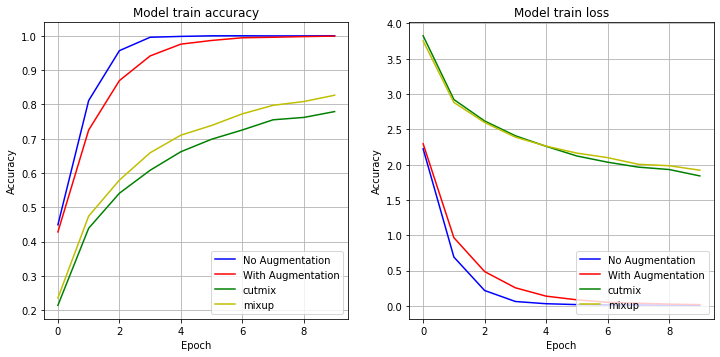

In [65]:
#train 과정 시각화

plt.figure(figsize=(12, 12))
plt.subplot(2,2,3)
plt.plot(history_resnet50_no_aug.history['accuracy'], 'b')
plt.plot(history_resnet50_aug.history['accuracy'], 'r')
plt.plot(history_resnet50_cutmix.history['accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['accuracy'], 'y')
plt.title('Model train accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','cutmix','mixup'], loc='lower right')
plt.grid(True)

plt.subplot(2,2,4)
plt.plot(history_resnet50_no_aug.history['loss'], 'b')
plt.plot(history_resnet50_aug.history['loss'], 'r')
plt.plot(history_resnet50_cutmix.history['loss'], 'g')
plt.plot(history_resnet50_mixup.history['loss'], 'y')
plt.title('Model train loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','cutmix','mixup'], loc='lower right')
plt.grid(True)

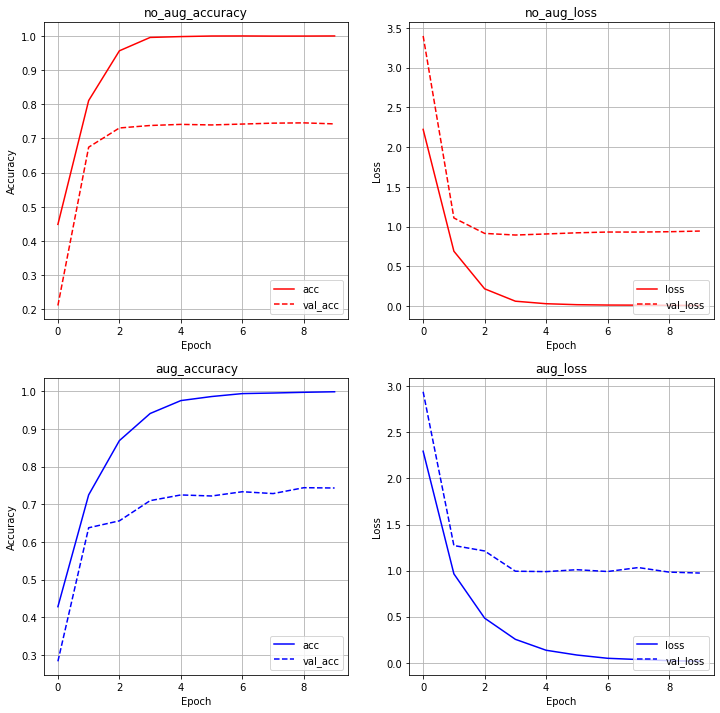

In [59]:
# 모델별 시각화
plt.figure(figsize=(12, 12))
plt.subplot(2,2,1)
plt.plot(history_resnet50_no_aug.history['accuracy'], 'r')
plt.plot(history_resnet50_no_aug.history['val_accuracy'], '--r')
plt.title('no_aug_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['acc', 'val_acc'], loc='lower right')
plt.grid(True)

plt.subplot(2,2,2)
plt.plot(history_resnet50_no_aug.history['loss'], 'r')
plt.plot(history_resnet50_no_aug.history['val_loss'], '--r')
plt.title('no_aug_loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='lower right')
plt.grid(True)

plt.subplot(2,2,3)
plt.plot(history_resnet50_aug.history['accuracy'], 'b')
plt.plot(history_resnet50_aug.history['val_accuracy'], '--b')
plt.title('aug_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['acc', 'val_acc'], loc='lower right')
plt.grid(True)

plt.subplot(2,2,4)
plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.plot(history_resnet50_aug.history['val_loss'], '--b')
plt.title('aug_loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='lower right')
plt.grid(True)

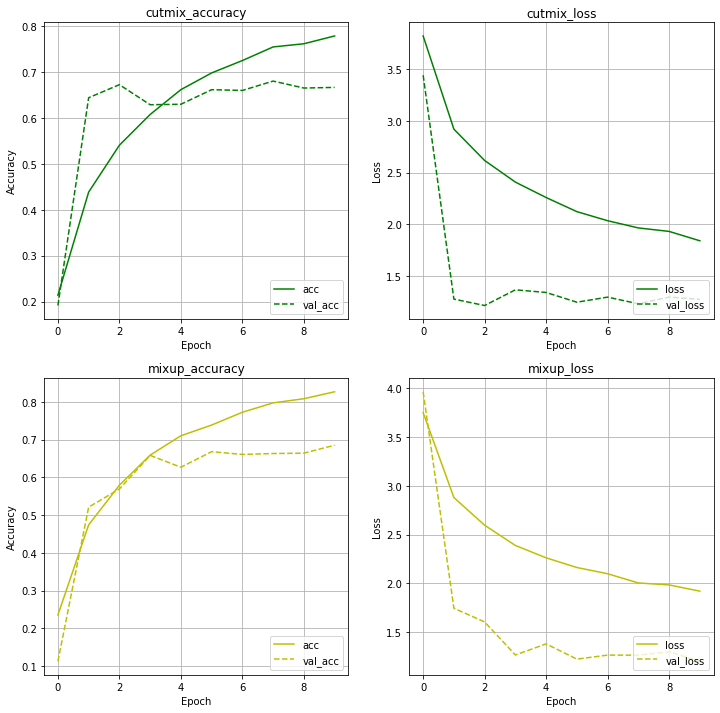

In [58]:
# 모델별 시각화
plt.figure(figsize=(12, 12))
plt.subplot(2,2,1)
plt.plot(history_resnet50_cutmix.history['accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], '--g')
plt.title('cutmix_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['acc', 'val_acc'], loc='lower right')
plt.grid(True)

plt.subplot(2,2,2)
plt.plot(history_resnet50_cutmix.history['loss'], 'g')
plt.plot(history_resnet50_cutmix.history['val_loss'], '--g')
plt.title('cutmix_loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='lower right')
plt.grid(True)

plt.subplot(2,2,3)
plt.plot(history_resnet50_mixup.history['accuracy'], 'y')
plt.plot(history_resnet50_mixup.history['val_accuracy'], '--y')
plt.title('mixup_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['acc', 'val_acc'], loc='lower right')
plt.grid(True)

plt.subplot(2,2,4)
plt.plot(history_resnet50_mixup.history['loss'], 'y')
plt.plot(history_resnet50_mixup.history['val_loss'], '--y')
plt.title('mixup_loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='lower right')
plt.grid(True)